In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
# read node data in coordinate (x,y) format
node_pw = pd.read_csv("D:\\Project Final Codes\\Project Final Codes\\Savings\\table1.csv")
print(node_pw)
start_time=time.time()


   node  d0  demand
0     0   0       0
1     1  25       4
2     2  43       6
3     3  57       5
4     4  43       4
5     5  55       4
6     6  48       6
7     7  35       5
8     8  18       3
9     9  28       5


In [3]:
pw = pd.read_csv("D:\\Project Final Codes\\Project Final Codes\\Savings\\table2.csv", index_col = 'Unnamed: 0')
pw.index.rename('',inplace = True)
pw

,1,2,3,4,5,6,7,8,9
,,,,,,,,,
1,0,29,34,43,68,49,66,72,91
2,29,0,52,72,96,72,81,89,114
3,34,52,0,45,71,71,95,99,108
4,43,72,45,0,27,36,65,65,65
5,68,96,71,27,0,40,66,62,46
6,49,72,71,36,40,0,31,31,43
7,66,81,95,65,66,31,0,11,46
8,72,89,99,65,62,31,11,0,36
9,91,114,108,65,46,43,46,36,0


In [4]:
savings = dict()
for r in pw.index:
    for c in pw.columns:
        if int(c) != int(r):            
            a = max(int(r), int(c))
            b = min(int(r), int(c))
            key = '(' + str(a) + ',' + str(b) + ')'
            #print(key)
            #print(r)
            #print(c)
            #print(pw[c][r])
            #print(node['d0'][int(r)])
            #print(node['d0'][int(c)])
            savings[key] = node_pw['d0'][int(r)] + node_pw['d0'][int(c)] - pw[c][r]
            print(savings)



{'(2,1)': 39}
{'(2,1)': 39, '(3,1)': 48}
{'(2,1)': 39, '(3,1)': 48, '(4,1)': 25}
{'(2,1)': 39, '(3,1)': 48, '(4,1)': 25, '(5,1)': 12}
{'(2,1)': 39, '(3,1)': 48, '(4,1)': 25, '(5,1)': 12, '(6,1)': 24}
{'(2,1)': 39, '(3,1)': 48, '(4,1)': 25, '(5,1)': 12, '(6,1)': 24, '(7,1)': -6}
{'(2,1)': 39, '(3,1)': 48, '(4,1)': 25, '(5,1)': 12, '(6,1)': 24, '(7,1)': -6, '(8,1)': -29}
{'(2,1)': 39, '(3,1)': 48, '(4,1)': 25, '(5,1)': 12, '(6,1)': 24, '(7,1)': -6, '(8,1)': -29, '(9,1)': -38}
{'(2,1)': 39, '(3,1)': 48, '(4,1)': 25, '(5,1)': 12, '(6,1)': 24, '(7,1)': -6, '(8,1)': -29, '(9,1)': -38}
{'(2,1)': 39, '(3,1)': 48, '(4,1)': 25, '(5,1)': 12, '(6,1)': 24, '(7,1)': -6, '(8,1)': -29, '(9,1)': -38, '(3,2)': 48}
{'(2,1)': 39, '(3,1)': 48, '(4,1)': 25, '(5,1)': 12, '(6,1)': 24, '(7,1)': -6, '(8,1)': -29, '(9,1)': -38, '(3,2)': 48, '(4,2)': 14}
{'(2,1)': 39, '(3,1)': 48, '(4,1)': 25, '(5,1)': 12, '(6,1)': 24, '(7,1)': -6, '(8,1)': -29, '(9,1)': -38, '(3,2)': 48, '(4,2)': 14, '(5,2)': 2}
{'(2,1)': 39, '(

In [5]:
# put savings in a pandas dataframe, and sort by descending
sv = pd.DataFrame.from_dict(savings, orient = 'index')
sv.rename(columns = {0:'saving'}, inplace = True)
sv.sort_values(by = ['saving'], ascending = False, inplace = True)
sv.head()

,saving
"(5,4)",71
"(6,5)",63
"(6,4)",55
"(4,3)",55
"(7,6)",52


In [6]:
# convert link string to link list to handle saving's key, i.e. str(10, 6) to (10, 6)
def get_node(link):
    link = link[1:]
    link = link[:-1]
    nodes = link.split(',')
    print(nodes)
    return [int(nodes[0]), int(nodes[1])]

In [7]:
# determine if a node is interior to a route
def interior(node, route):
    try:
        i = route.index(node)
        # adjacent to depot, not interior
        if i == 0 or i == (len(route) - 1):
            label = False
        else:
            label = True
    except:
        label = False
    
    return label

In [8]:
# merge two routes with a connection link
def merge(route0, route1, link):
    if route0.index(link[0]) != (len(route0) - 1):
        route0.reverse()
    
    if route1.index(link[1]) != 0:
        route1.reverse()
        
    return route0 + route1

In [9]:
# sum up to obtain the total deliveries belonging to a route
def sum_cap(route):
    sum_cap = 0
    for node in route:
        sum_cap += node_pw.demand[node]
    return sum_cap

In [10]:
# determine 4 things:
# 1. if the link in any route in routes -> determined by if count_in > 0
# 2. if yes, which node is in the route -> returned to node_sel
# 3. if yes, which route is the node belongs to -> returned to route id: i_route
# 4. are both of the nodes in the same route? -> overlap = 1, yes; otherwise, no
def which_route(link, routes):
    # assume nodes are not in any route
    node_sel = list()
    i_route = [-1,-1]
    count_in = 0
    
    for route in routes:
        for node in link:
            try:
                route.index(node)
                i_route[count_in] = routes.index(route)
                node_sel.append(node)
                count_in += 1
            except:
                a = 1
                
    if i_route[0] == i_route[1]:
        overlap = 1
    else:
        overlap = 0
        
    return node_sel, count_in, i_route, overlap

In [11]:
# create empty routes
routes = list()

# if there is any remaining customer to be served
remaining = True

# determine capacity of the vehicle
cap = 45

# record steps
step = 0

# get a list of nodes, excluding the depot
node_list = list(node_pw.index)
node_list.remove(0)

# run through each link in the saving list
for link in sv.index:
    step += 1
    if remaining:

        print('step ', step, ':')

        link = get_node(link)
        node_sel, num_in, i_route, overlap = which_route(link, routes)

        # condition a. Either, neither i nor j have already been assigned to a route, 
        # ...in which case a new route is initiated including both i and j.
        if num_in == 0:
            if sum_cap(link) <= cap:
                routes.append(link)
                node_list.remove(link[0])
                node_list.remove(link[1])
                print('\t','Link ', link, ' fulfills criteria a), so it is created as a new route')
            else:
                print('\t','Though Link ', link, ' fulfills criteria a), it exceeds maximum load, so skip this link.')

        # condition b. Or, exactly one of the two nodes (i or j) has already been included 
        # ...in an existing route and that point is not interior to that route 
        # ...(a point is interior to a route if it is not adjacent to the depot D in the order of traversal of nodes), 
        # ...in which case the link (i, j) is added to that same route.    
        elif num_in == 1:
            n_sel = node_sel[0]
            i_rt = i_route[0]
            position = routes[i_rt].index(n_sel)
            link_temp = link.copy()
            link_temp.remove(n_sel)
            node = link_temp[0]

            cond1 = (not interior(n_sel, routes[i_rt]))
            cond2 = (sum_cap(routes[i_rt] + [node]) <= cap)

            if cond1:
                if cond2:
                    print('\t','Link ', link, ' fulfills criteria b), so a new node is added to route ', routes[i_rt], '.')
                    if position == 0:
                        routes[i_rt].insert(0, node)
                    else:
                        routes[i_rt].append(node)
                    node_list.remove(node)
                else:
                    print('\t','Though Link ', link, ' fulfills criteria b), it exceeds maximum load, so skip this link.')
                    continue
            else:
                print('\t','For Link ', link, ', node ', n_sel, ' is interior to route ', routes[i_rt], ', so skip this link')
                continue

        # condition c. Or, both i and j have already been included in two different existing routes 
        # ...and neither point is interior to its route, in which case the two routes are merged.        
        else:
            if overlap == 0:
                cond1 = (not interior(node_sel[0], routes[i_route[0]]))
                cond2 = (not interior(node_sel[1], routes[i_route[1]]))
                cond3 = (sum_cap(routes[i_route[0]] + routes[i_route[1]]) <= cap)

                if cond1 and cond2:
                    if cond3:
                        route_temp = merge(routes[i_route[0]], routes[i_route[1]], node_sel)
                        temp1 = routes[i_route[0]]
                        temp2 = routes[i_route[1]]
                        routes.remove(temp1)
                        routes.remove(temp2)
                        routes.append(route_temp)
                        node_list.remove(link[0])
                        node_list.remove(link[1])
                        print('\t','Link ', link, ' fulfills criteria c), so route ', temp1, ' and route ', temp2, ' are merged')
                    else:
                        print('\t','Though Link ', link, ' fulfills criteria c), it exceeds maximum load, so skip this link.')
                        continue
                else:
                    print('\t','For link ', link, ', Two nodes are found in two different routes, but not all the nodes fulfill interior requirement, so skip this link')
                    continue
            else:
                print('\t','Link ', link, ' is already included in the routes')
                continue

        for route in routes: 
            print('\t','route: ', route, ' with load ', sum_cap(route))
    else:
        print('-------')
        print('All nodes are included in the routes, algorithm closed')
        break

    remaining = bool(len(node_list) > 0)

# check if any node is left, assign to a unique route
for node_o in node_list:
    routes.append([node_o])

# add depot to the routes
for route in routes:
    route.insert(0,0)
    #route.append(0)

print('------')
route.append(0)
print('Routes found are: ',route)
routes
exec_time=start_time-time.time()
print("The execution time is: ",-exec_time)
k=324
print("Cost:",k)

step  1 :
['5', '4']
	 Link  [5, 4]  fulfills criteria a), so it is created as a new route
	 route:  [5, 4]  with load  8
step  2 :
['6', '5']
	 Link  [6, 5]  fulfills criteria b), so a new node is added to route  [5, 4] .
	 route:  [6, 5, 4]  with load  14
step  3 :
['6', '4']
	 Link  [6, 4]  is already included in the routes
step  4 :
['4', '3']
	 Link  [4, 3]  fulfills criteria b), so a new node is added to route  [6, 5, 4] .
	 route:  [6, 5, 4, 3]  with load  19
step  5 :
['7', '6']
	 Link  [7, 6]  fulfills criteria b), so a new node is added to route  [6, 5, 4, 3] .
	 route:  [7, 6, 5, 4, 3]  with load  24
step  6 :
['3', '1']
	 Link  [3, 1]  fulfills criteria b), so a new node is added to route  [7, 6, 5, 4, 3] .
	 route:  [7, 6, 5, 4, 3, 1]  with load  28
step  7 :
['3', '2']
	 For Link  [3, 2] , node  3  is interior to route  [7, 6, 5, 4, 3, 1] , so skip this link
step  8 :
['8', '7']
	 Link  [8, 7]  fulfills criteria b), so a new node is added to route  [7, 6, 5, 4, 3, 1] .
	 

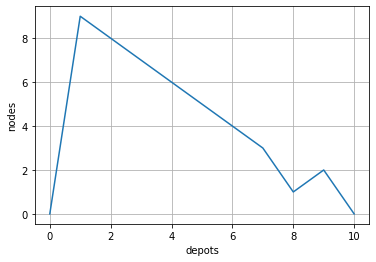

In [23]:
#depots=(0,0,0,0,0,0,0,0,0,0,0)
plt.xlabel('depots')
plt.ylabel('nodes')
plt.plot(route)
plt.grid()
plt.show()